## A simple Autoencoder to be trained on GPU/CPU 

### Aimed at compressing Stokes I (for now) for synthesized observed photospheric spectral lines 

### various training and validation sets available at: 

https://drive.google.com/drive/folders/1SO4FyyX_X878FAcU7k1zD6AkOvFyWMH4?usp=sharing

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
class conv_ae(nn.Module):
    
    def __init__(self, inputsize, bottleneck):
        
        super(conv_ae, self).__init__()
        
        self.NS = inputsize[0]
        self.NL = inputsize[1]
        
        # Encoder part:
        
        self.conv1 = nn.Conv1d(self.NS, 8, 3, padding=1, padding_mode='replicate')
        self.conv2 = nn.Conv1d(8, 8, 3, padding=1, padding_mode='replicate')
        
        self.maxpool2 = nn.MaxPool1d(2)
        
        self.linear1 = nn.Linear(8*self.NL//4, 60)
        self.linear2 = nn.Linear(60, 30)
        self.linear3 = nn.Linear(30, bottleneck)
        
        self.ractivation = nn.ReLU()
        self.sactivation = nn.Sigmoid()
        
        # Decoder part:
        
        self.linear1o = nn.Linear(bottleneck, 30)
        self.linear2o = nn.Linear(30,60)
        self.linear3o = nn.Linear(60, 8*self.NL//4)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv1o = nn.Conv1d(8, 8, 3, padding=1, padding_mode='replicate')
        self.conv2o = nn.Conv1d(8, self.NS, 3, padding=1, padding_mode='replicate')
        
        
        
    def encode (self, x):
        
        out = self.conv1(x)
        out = self.maxpool2(out)
        out = self.ractivation(out)
        
        out = self.conv2(out)
        out = self.maxpool2(out)
        out = self.ractivation(out)
        
        out = torch.reshape(out, (-1,))
        
        out = self.linear1(out)
        out = self.ractivation(out)
        out = self.linear2(out)
        out = self.ractivation(out)
        out = self.linear3(out)
        out = self.sactivation(out)
        
        return out
    
    def decode (self, x):
        
        out = self.linear1o(x)
        out = self.ractivation(out)
        out = self.linear2o(out)
        out = self.ractivation(out)
        out = self.linear3o(out)
        out = self.ractivation(out)
        
        out = torch.reshape(out,(1,8,-1,))
        
        
        out = self.upsample2(out)
        out = torch.reshape(out,(8,-1,))
        out = self.conv1o(out)
        out = self.ractivation(out)
        
        out = torch.reshape(out,(1,8,-1,))
        out = self.upsample2(out)
        out = torch.reshape(out,(8,-1,))
        out = self.conv2o(out)
        out = self.sactivation(out)
        
        return out
    
    def forward(self, x):
        
        compressed = self.encode(x);
        restored   = self.decode(compressed);
        
        return restored;

In [3]:
def make_conv_model(cudaoption, inputsize, bottleneck):
    
    model = conv_ae(inputsize, bottleneck)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model 

def conv_model_encode (model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.encode(inputdata)
    
    output = output.to("cpu")
    return output

def conv_model_decode (model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.decode(inputdata)
    
    output = output.to("cpu")
    return output

def conv_model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output
    

In [4]:
cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)
ae_model = make_conv_model(cudaoption, [4, 112], 12)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0
[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


In [5]:
random_in = np.random.uniform(0, 1, (4,112))
print(random_in.shape)

data_torch = torch.from_numpy(random_in.astype('float32'))

test = conv_model_encode(ae_model, data_torch, cudaoption)

test.shape

(4, 112)


torch.Size([12])

In [6]:
test_out = conv_model_decode(ae_model, test, cudaoption)
test_out.shape

torch.Size([4, 112])

In [7]:
test_predict = conv_model_predict(ae_model, data_torch, cudaoption)
test_predict.shape

torch.Size([4, 112])

### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [8]:
from astropy.io import fits 

In [9]:
data = fits.open("C:/Data/Hinode_ML_compression/training_sample_5c_vector.fits")[0].data

In [10]:
data.shape

(150000, 4, 112)

In [11]:
#stokes = stokes[:256,:256,0,:]
#print (stokes.shape)
#stokes = stokes[:,:,::2]
#print (stokes.shape)
#data = stokes.reshape(256*256,201)

In [12]:
#del(stokes)

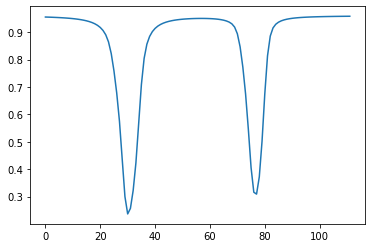

In [13]:
plt.plot(data[0,0])

In [14]:
data_norm = np.copy(data)

In [15]:
# If you want to normalize wavelength wise (not a good idea imho)

#for l in range(0,201):
#    data_norm[:,l] = (data[:,l] - np.amin(data[:,l])) / (np.amax(data[:,l])-np.amin(data[:,l]))

In [16]:
dmax = np.amax(data[:,0,:])
dmin = np.amin(data[:,0,:])

In [17]:
data_norm[:,:,:] = (data[:,:,:] - np.amin(data[:,:])) / (np.amax(data[:,:,:])-np.amin(data[:,:,:]))

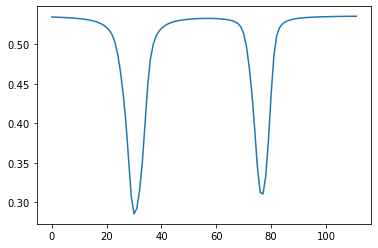

In [18]:
plt.plot(data_norm[0,0])
data_norm[:,1:4,:] *= 5.0

In [19]:
#del(data)

In [20]:
data_torch = torch.from_numpy(data_norm.astype('float32'))
data_torch.shape

torch.Size([150000, 4, 112])

In [24]:
test_output = conv_model_predict(ae_model,data_torch[:10,:,:],cudaoption)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2240 and 224x60)

In [23]:
test_output.shape

torch.Size([4, 112])

In [ ]:
plt.plot(test_output[0].detach().numpy())

In [ ]:
test_compress = model_encode(ae_model, data_torch[:10],cudaoption)
test_compress.shape

In [ ]:
plt.plot(test_compress[0].detach().numpy())

In [ ]:
## Let's make a function to train:

def compilefit(model, data, nepochs, criterion, cudaoption, lri, output_interval, batch):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri)
    loss_fn = nn.MSELoss()
    
    if cudaoption:
        data = data.to(device)
        
    performance = np.zeros(nepochs)
    
    N_data = len(data[:,0])
    N_batches = N_data // batch
            
    for i in range(0,nepochs):
        
        indices = np.arange(N_data)
        indices = np.random.permutation(indices)
        
        #for j in range(0, N_batches):
            
            #data_batch = Subset(data, indices[j*batch:(j+1)*batch])
        
        optimizer.zero_grad()
        out = model.forward(data)
             
        loss = loss_fn(data,out)
        loss.backward()
        optimizer.step()
        performance[i] = loss.item()
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - loss : {loss.item():.6f} - residual std : {np.sqrt(loss.item()):.6f}')
    return performance

In [ ]:
# Create model again as the above was just testing:
ae_model = make_model(cudaoption, 112, 8)

In [ ]:
summary(ae_model,input_size=(1,112))

In [ ]:
nepochs = 1000

#convergence = compilefit(ae_model, data_torch, 1000, 0, cudaoption, 1E-2, 200, 256)
#convergence = compilefit(ae_model, data_torch, 5000, 0, cudaoption, 5E-3, 200, 256)
#convergence = compilefit(ae_model, data_torch, 20000, 0, cudaoption, 2E-3, 200, 256)
convergence = compilefit(ae_model, data_torch, 20000, 0, cudaoption, 1E-3, 200, 256)

In [ ]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence) 

In [ ]:
test_train = test_output = model_predict(ae_model,data_torch[:10],cudaoption)
test_train.shape

In [ ]:
bla = test_train.detach().numpy()

In [ ]:
plt.figure(figsize=[10,7])
plt.subplot(121)
for i in range(0,10):
    plt.plot(bla[i])
plt.subplot(122)
for i in range(0,10):
    plt.plot(data_norm[i])



### Here we do some statistical analysis of the "compression"

In [ ]:
test_output = model_predict(ae_model,data_torch,cudaoption)

In [ ]:
data_reconstructed = test_output.detach().numpy()

In [ ]:
# de-normalize

data_reconstructed  = data_reconstructed * (dmax-dmin) + dmin

In [ ]:
noise = np.mean(data[:,0]) * 7E-3

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,5])

In [ ]:
# Example plots 

i = 4513

plt.figure(figsize=[10,6])
plt.plot(data[i], label = 'Original')
plt.plot(data_reconstructed[i], label = 'Compressed')
plt.legend()

In [ ]:
torch.save(ae_model, 'hinode_encoding_8.pt')

### Simple validation here:

In [ ]:
ae_model = torch.load('hinode_encoding_6.pt')

In [ ]:
data_val = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_synth_1_1_hinodewvl.fits")[0].data

In [ ]:
data_val = data_val[:,:,0,:].reshape(768*768, 112)

In [ ]:
data_val = (data_val - dmin) / (dmax-dmin)

In [ ]:
data_val = torch.from_numpy(data_val.astype('float32'))

In [ ]:
data_val_predicted = model_predict(ae_model,data_val, cudaoption)

In [ ]:
data_val_predicted = data_val_predicted.detach().numpy()
data_val = data_val.detach().numpy()

In [ ]:
data_val_predicted = data_val_predicted * (dmax-dmin) + dmin
data_val = data_val * (dmax-dmin) + dmin

In [ ]:
#noise = np.mean(data[:,0]) * 7E-3

residual = (data_val - data_val_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisq.flatten(),bins=50,range=[0,5])

In [ ]:
# Example plots 

i = 1313

plt.figure(figsize=[10,6])
plt.plot(data_val[i])
plt.plot(data_val_predicted[i])

In [ ]:
data_val = torch.from_numpy(data_val.astype('float32'))
data_val_compressed = model_encode(ae_model,data_val, cudaoption)

In [ ]:
data_val_compressed = data_val_compressed.detach().numpy()

In [ ]:
data_val_compressed = data_val_compressed.reshape(768,768,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, figsize=[17.5,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(data_val_compressed[:,:,i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')